In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import sys
import re
import os
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import numpy as np

import librosa
import librosa.display

import cv2
import zipfile
from PIL import Image

import time
import copy

# Get accent archive

In [ ]:
%cd /content/drive/MyDrive/NIS_2022/accent_archive

/content/drive/MyDrive/NIS_2022/accent_archive


In [ ]:
!git clone https://github.com/akshanshchaudhry/Speech-Accent-Recognition.git

Cloning into 'Speech-Accent-Recognition'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.


In [ ]:
!pip install pydub

In [ ]:
%cd ../Speech-Accent-Recognition/src

/content/drive/MyDrive/NIS_2022/accent_archive/Speech-Accent-Recognition/src


In [ ]:
!python fromwebsite.py /content/drive/MyDrive/NIS_2022/accent_archive/data/bio_metadata.csv  chinese english russian japanese arabic spanish korean

downloading from http://accent.gmu.edu/browse_language.php?function=find&language=japanese
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=221
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=222
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=223
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=224
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=225
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=226
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=227
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=486
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=543
downloading from http://accent.gmu.edu/browse_language.php?function=detail&speakerid=827
downloading from ht

In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/NIS_2022/accent_archive/data/processed_bio_metadata.csv',
                  sep='\t')

In [ ]:
categories = []
for index, row in df.iterrows():
    category = 'default'
    if 'china' in row['birth_place'] or 'taiwan' in row['birth_place']:
        category = 'chinese'
    elif 'english' in row['language_num']:
        if 'usa' in row['birth_place']:
            category = 'usa'
        elif 'uk' in row['birth_place']:
            category = 'uk'
        elif 'canada' in row['birth_place']:
            category = 'canada'
        elif 'australia' in row['birth_place']:
            category = 'australia'
    elif 'russian' in row['language_num']:
        category = 'russian'
    elif 'arabic' in row['language_num']:
        category = 'arabic'
    elif 'spanish' in row['language_num']:
        category = 'spanish'
    elif 'korean' in row['language_num']:
        category = 'korean'
    elif 'japanese' in row['language_num']:
        category = 'japanese'
    categories.append(category)
    

In [ ]:
df['category'] = categories

In [ ]:
len(categories)

1521

In [ ]:
df.to_csv(r'/content/drive/MyDrive/NIS_2022/accent_archive/data/processed_bio_metadata.csv', index=False, sep='\t', header='true')

In [ ]:
!python getaudio.py /content/drive/MyDrive/NIS_2022/accent_archive/data/processed_bio_metadata.csv

# Dataset create

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    path = os.fspath(file_path)
    wav,sr = librosa.load(path,sr=sr)
    # if wav.shape[0]<5*sr:
    #     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    # else:
    #     wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [ ]:
audio_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/audio/'
mel_spectrograms_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/mel_spectrograms/'

train_dir = mel_spectrograms_dir + 'train'
valid_dir = mel_spectrograms_dir + 'validation'

In [ ]:
for subdir, dirs, files in os.walk(audio_dir):
    if len(files) == 0: 
        continue
    accent = os.path.basename(subdir)
    train, test = train_test_split(files, test_size=0.2)
    for audio_file in train:
        audio_path = os.path.join(subdir, audio_file)
        try:
          melspectrogram = spec_to_image(get_melspectrogram_db(audio_path))
        except:
            continue
        img = Image.fromarray(melspectrogram)
        save_path = train_dir + '/' + accent
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img.save(save_path+'/'+os.path.splitext(os.path.basename(audio_path))[0]+'.png')

    for audio_file in test:
        audio_path = os.path.join(subdir, audio_file)
        try:
          melspectrogram = spec_to_image(get_melspectrogram_db(audio_path))
        except:
            continue
        img = Image.fromarray(melspectrogram)
        save_path = valid_dir + '/' + accent
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img.save(save_path+'/'+os.path.splitext(os.path.basename(audio_path))[0]+'.png')

# Resnet fine-tuning

## Data Loading

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torchvision.models as models

In [3]:
from sklearn.model_selection import train_test_split
import os
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder  
import librosa
import librosa.display

In [4]:
# input_size = 224
batch_size = 32

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
audio_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/audio/'

In [7]:
speakers_train_paths = []
speakers_train_labels = []

speakers_test_paths = []
speakers_test_labels = []

In [8]:
ban = ['australia', 'canada', 'japanese']
for subdir, dirs, files in os.walk(audio_dir):
    if len(files) == 0: 
        continue
    accent = os.path.basename(subdir)
    if accent in ban:
        continue
    train, test = train_test_split(files, test_size=0.2)
    for audio_file in train:
        audio_path = os.path.join(subdir, audio_file)
        try:
          wav, sr = librosa.load(audio_path,sr=None)
          speakers_train_paths.append(audio_path)
          speakers_train_labels.append(accent)
        except:
            continue

    for audio_file in test:
        audio_path = os.path.join(subdir, audio_file)
        try:
          wav, sr = librosa.load(audio_path,sr=None)
          speakers_test_paths.append(audio_path)
          speakers_test_labels.append(accent)
        except:
            continue

In [9]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

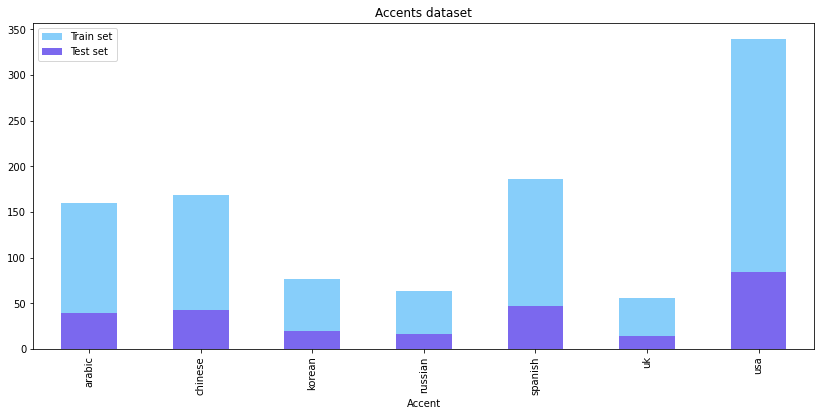

In [10]:
unique_elements_train, counts_elements_train = np.unique(le.inverse_transform(speakers_train_labels), 
                                                         return_counts=True)

unique_elements_test, counts_elements_test = np.unique(le.inverse_transform(speakers_test_labels), 
                                                       return_counts=True)

df = pd.DataFrame({
    'Accent': unique_elements_train,
    'Train set': counts_elements_train,
    'Test set': counts_elements_test
})
  
ax = df.plot(x="Accent", y='Train set', kind="bar", figsize=(14, 6), color="lightskyblue")
df.plot(x="Accent", y='Test set', kind="bar", ax=ax, color="mediumslateblue")
plt.title('Accents dataset')
plt.show()

In [14]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                 window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        fbank = self._wav2fbank(filename)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -6.757296
        norm_std = 4.3780417
        fbank = (fbank - norm_mean) / (norm_std * 2)
        fbank = torch.reshape(fbank, (1, 128, 256))
        fbank = fbank.expand(3, -1, -1)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [16]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

In [13]:
# mean=[]
# std=[]
# for i, (audio_input, labels) in enumerate(train_loader):
#     cur_mean = torch.mean(audio_input)
#     cur_std = torch.std(audio_input)
#     mean.append(cur_mean)
#     std.append(cur_std)
#     print(cur_mean, cur_std)
# print(np.mean(mean), np.mean(std))

tensor(-6.9430) tensor(4.3433)
tensor(-6.8455) tensor(4.5177)
tensor(-7.4912) tensor(4.3532)
tensor(-6.6834) tensor(4.4257)
tensor(-6.6167) tensor(4.4717)
tensor(-6.8855) tensor(4.3244)
tensor(-6.3951) tensor(4.0690)
tensor(-6.4353) tensor(4.3093)
tensor(-6.8338) tensor(4.4711)
tensor(-6.8109) tensor(4.3764)
tensor(-6.2849) tensor(4.1857)
tensor(-6.6923) tensor(4.3278)
tensor(-6.5970) tensor(4.3776)
tensor(-6.5700) tensor(4.2566)
tensor(-6.8078) tensor(4.4495)
tensor(-6.8852) tensor(4.1533)
tensor(-6.9340) tensor(4.1905)
tensor(-6.9359) tensor(4.5609)
tensor(-6.3158) tensor(4.2634)
tensor(-7.1697) tensor(4.4570)
tensor(-6.8247) tensor(4.6292)
tensor(-6.9538) tensor(4.4126)
tensor(-6.8183) tensor(4.3098)
tensor(-6.9074) tensor(4.5530)
tensor(-6.5337) tensor(4.2833)
tensor(-6.9763) tensor(4.2872)
tensor(-6.4060) tensor(4.4559)
tensor(-6.6168) tensor(4.4099)
tensor(-6.9023) tensor(4.3767)
tensor(-6.6344) tensor(4.3725)
tensor(-6.5805) tensor(4.5154)
tensor(-7.1317) tensor(4.5579)
tensor(-

In [6]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'validation': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# mel_spectrograms_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/mel_spectrograms/'
# image_datasets = {x: ImageFolder(os.path.join(mel_spectrograms_dir, x), data_transforms[x]) for x in ['train', 'validation']}

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight                         

In [ ]:
# weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
# weights = torch.DoubleTensor(weights)                                       
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

In [ ]:
# dataloaders_dict = {}
# dataloaders_dict['train'] = torch.utils.data.DataLoader(image_datasets['train'], 
#                                                    batch_size=batch_size, 
#                                                   #  shuffle=True, 
#                                                    sampler=sampler,
#                                                    num_workers=4) 

In [ ]:
# dataloaders_dict['validation'] = torch.utils.data.DataLoader(image_datasets['validation'], 
#                                                    batch_size=batch_size, 
#                                                    shuffle=True, 
#                                                    num_workers=4) 

In [7]:
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
#                                                    batch_size=batch_size, 
#                                                    shuffle=True, 
#                                                    num_workers=4) for x in ['train', 'validation']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Train & Evaluate

In [17]:
num_classes = 7
num_epochs = 5

In [18]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.fc = nn.Linear(512, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # try:
                #     inputs = inputs.reshape((10, 128, 128))
                # except:
                #     continue
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    
                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    
                    loss = criterion(outputs, labels)
                    # loss = criterion(outputs, labels)

                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
resnet18_pretrained = resnet18_pretrained.to(device)

params_to_update = resnet18_pretrained.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

In [22]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
resnet18_pretrained, hist = train_model(resnet18_pretrained,
                             dataloaders_dict,
                             criterion, optimizer_ft, 
                             num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 1.9422 Acc: 0.2329
validation Loss: 1.9152 Acc: 0.3195

Epoch 1/4
----------
train Loss: 1.7420 Acc: 0.3165
validation Loss: 1.7648 Acc: 0.3120

Epoch 2/4
----------
train Loss: 1.6624 Acc: 0.3717
validation Loss: 1.7468 Acc: 0.3421

Epoch 3/4
----------
train Loss: 1.6081 Acc: 0.3945
validation Loss: 1.7284 Acc: 0.3383

Epoch 4/4
----------
train Loss: 1.5485 Acc: 0.4259
validation Loss: 1.7097 Acc: 0.3459

Training complete in 6m 6s
Best val Acc: 0.345865


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
resnet18_pretrained.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = resnet18_pretrained(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [24]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.19      0.07      0.11        40
           1       0.26      0.14      0.18        43
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        17
           4       0.18      0.19      0.19        47
           5       0.00      0.00      0.00        14
           6       0.42      0.87      0.56        85

    accuracy                           0.35       266
   macro avg       0.15      0.18      0.15       266
weighted avg       0.24      0.35      0.26       266



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
confusion_matrix(y_labels_list, y_pred_list)

array([[ 3,  5,  0,  0, 16,  0, 16],
       [ 3,  6,  0,  0,  5,  0, 29],
       [ 2,  3,  0,  0,  8,  0,  7],
       [ 1,  2,  0,  0,  3,  0, 11],
       [ 4,  3,  0,  0,  9,  0, 31],
       [ 1,  1,  0,  0,  3,  0,  9],
       [ 2,  3,  0,  0,  6,  0, 74]])

In [27]:
le.classes_

array(['arabic', 'chinese', 'korean', 'russian', 'spanish', 'uk', 'usa'],
      dtype='<U7')

# Transformer fine-tuning

## Model loading

In [36]:
pip install timm==0.4.5

     |████████████████████████████████| 287 kB 8.6 MB/s 


In [37]:
from torch.cuda.amp import autocast
import os
import timm
from timm.models.layers import to_2tuple,trunc_normal_


In [56]:
# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (256, 128)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        # assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            # if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
            # audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
            # wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            
            sd = torch.load('/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4495.pth', map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, 
                                   imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [57]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4495.pth'
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
input_tdim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_model = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                       input_tdim=input_tdim, label_dim=7)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=144


In [34]:
audio_model = audio_model.to(device)

In [25]:
# test_input = torch.rand([16, input_tdim, 128]).to(device)
# test_output = audio_model(test_input)

## Train & Evaluate

In [35]:
input_size = 128
batch_size = 10

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

mel_spectrograms_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/mel_spectrograms/'
image_datasets = {x: ImageFolder(os.path.join(mel_spectrograms_dir, x), data_transforms[x]) for x in ['train', 'validation']}

In [37]:
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'validation']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 0.001, weight_decay=5e-7, betas=(0.95, 0.999))
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [23]:
num_epochs = 10

In [24]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                criterion, optimizer, 
                                num_epochs=num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.2603 Acc: 0.2312
validation Loss: 2.0668 Acc: 0.2891

Epoch 1/9
----------
train Loss: 2.0573 Acc: 0.2823
validation Loss: 2.0271 Acc: 0.2891

Epoch 2/9
----------
train Loss: 2.0349 Acc: 0.2909
validation Loss: 2.0093 Acc: 0.2959

Epoch 3/9
----------
train Loss: 2.0030 Acc: 0.2909
validation Loss: 2.0170 Acc: 0.2823

Epoch 4/9
----------
train Loss: 2.0167 Acc: 0.2814
validation Loss: 2.0113 Acc: 0.2381

Epoch 5/9
----------
train Loss: 1.9820 Acc: 0.2909
validation Loss: 1.9981 Acc: 0.2925

Epoch 6/9
----------
train Loss: 1.9747 Acc: 0.2961
validation Loss: 2.0597 Acc: 0.2789

Epoch 7/9
----------
train Loss: 1.9927 Acc: 0.2745
validation Loss: 2.0016 Acc: 0.2517

Epoch 8/9
----------
train Loss: 1.9898 Acc: 0.3074
validation Loss: 1.9942 Acc: 0.2585

Epoch 9/9
----------
train Loss: 1.9602 Acc: 0.3091
validation Loss: 2.0414 Acc: 0.2449

Training complete in 2m 31s
Best val Acc: 0.295918


# Transformer fine-tuning + ast data prepocessing

## Data loading

In [35]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
audio_dir = '/content/drive/MyDrive/NIS_2022/accent_archive/data/audio/'

In [39]:
speakers_train_paths = []
speakers_train_labels = []

speakers_test_paths = []
speakers_test_labels = []

In [40]:
for subdir, dirs, files in os.walk(audio_dir):
    if len(files) == 0: 
        continue
    accent = os.path.basename(subdir)
    train, test = train_test_split(files, test_size=0.2)
    for audio_file in train:
        audio_path = os.path.join(subdir, audio_file)
        try:
          wav, sr = librosa.load(audio_path,sr=None)
          speakers_train_paths.append(audio_path)
          speakers_train_labels.append(accent)
        except:
            continue

    for audio_file in test:
        audio_path = os.path.join(subdir, audio_file)
        try:
          wav, sr = librosa.load(audio_path,sr=None)
          speakers_test_paths.append(audio_path)
          speakers_test_labels.append(accent)
        except:
            continue

In [41]:
speaker_set = set(speakers_test_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{'uk', 'canada', 'spanish', 'korean', 'japanese', 'arabic', 'chinese', 'usa', 'australia', 'russian'}


In [42]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

In [43]:
speaker_set = set(speakers_test_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [28]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                 window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 128
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        fbank = self._wav2fbank(filename)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -6.757296
        norm_std = 4.3780417
        fbank = (fbank - norm_mean) / (norm_std * 2)

        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [29]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [30]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

## Model loading

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4495.pth'
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
input_tdim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_model = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                       input_tdim=input_tdim, label_dim=7)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=144


In [59]:
audio_model = audio_model.to(device)

## Train & Evaluate

In [60]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # try:
                #     inputs = inputs.reshape((10, 128, 128))
                # except:
                #     continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    
                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    
                    
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [61]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 0.0001, weight_decay=5e-7, betas=(0.95, 0.999))

In [62]:
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

In [63]:
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                loss_fn, optimizer, 
                                num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 1.9920 Acc: 0.3327
validation Loss: 1.8267 Acc: 0.3195

Epoch 1/4
----------
train Loss: 1.7446 Acc: 0.3593
validation Loss: 1.7417 Acc: 0.3609

Epoch 2/4
----------
train Loss: 1.6875 Acc: 0.3574
validation Loss: 1.7409 Acc: 0.3571

Epoch 3/4
----------
train Loss: 1.6863 Acc: 0.3584
validation Loss: 1.7502 Acc: 0.3496

Epoch 4/4
----------
train Loss: 1.6948 Acc: 0.3612
validation Loss: 1.7424 Acc: 0.3571

Training complete in 7m 14s
Best val Acc: 0.360902


In [64]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [65]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.23      0.47      0.31        40
           1       0.29      0.05      0.08        43
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        47
           5       0.00      0.00      0.00        14
           6       0.43      0.88      0.58        85

    accuracy                           0.36       266
   macro avg       0.13      0.20      0.14       266
weighted avg       0.22      0.36      0.24       266



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
confusion_matrix(y_labels_list, y_pred_list)

array([[19,  2,  0,  0,  0,  0, 19],
       [15,  2,  0,  0,  0,  0, 26],
       [11,  0,  0,  0,  0,  0,  9],
       [ 8,  0,  0,  0,  0,  0,  9],
       [17,  2,  0,  0,  0,  0, 28],
       [ 4,  1,  0,  0,  0,  0,  9],
       [10,  0,  0,  0,  0,  0, 75]])